#### 1. 관서명, 살인발생, ... <= 컬럼명

  | 관서명 | 살인발생 | 살인검거 |
  | ------ | ------| ------ |
  | 중부  |    2 |  2   |
 
#### 2. 관서명(구분)이 인덱스, 살인발생, ... 컬럼명 

   |살인발생|살인검거|
   | ------| ------ |
   |    2   |  2     |

## 위의 형태로 Datafram이 나오게끔 2017년 csv를 읽어서 위의 형태로 구성 하시오 

In [4]:
import pandas as pd
import numpy as np

## 데이터 확득하기 
[5대범죄현황](https://www.data.go.kr/dataset/3075835/fileData.do)
폴더 이름을seoul_crime 로 변경한후 data 폴더에 저장
### pandas를 이용해 데이터를 정리
다운받은 파일을 변수에 저장한다.

In [5]:
# 한글명 제거후 로드 
#pd.read_csv('../data/seoul_crime/2017.csv', encoding='euc-kr')
#engine옵션이 c, python으로 나눠져서 파싱을 하게됨 
# 기본 값이 c엔진이라 한글이 깨지는 경우가 더러 잇음 
# python엔진으로 설명하면 파일명 및 파일 내용의 인코딩가지 자동으로 처리함 
crime_raw_data = pd.read_csv('../data/seoul_crime/2017년.csv', engine='python')
crime_raw_data.shape

(310, 4)

In [6]:
crime_raw_data.head()

,구분,죄종,발생검거,건수
0,중부,살인,발생,0
1,중부,살인,검거,0
2,중부,강도,발생,6
3,중부,강도,검거,6
4,중부,강간,발생,173


- numpy 

    배열은 동일한 타입의 값들을 가지며, 
    배열의 차원을 rank 라 하고, 
    각 차원의 크기를 튜플로 표시하는 것을 shape 라 한다. 
    예를 들어, 행이 2이고 열이 3인 2차원 배열에서 rank는 2 이고,
     shape는 (2, 3) 이 된다.
     
 #### 총관할서의 수 = crime_raw_data.shape[0] / 10 => 31


In [7]:
# 5대 범죄 *2(발생, 검거) => 관할서당 데이터는 10개 
# 총관할서의 수 = crime_raw_data.shape[0]/10 => 31
crime_raw_data.shape[0]/10

31.0

In [8]:
# 그러므로 데이터 구조의 데이터 수는 (31,10) 이런 형태로 출력되면 OK
tmp = pd.pivot_table( crime_raw_data,
                     index = ['구분'],
                     columns = ['죄종','발생검거']
                    )
tmp.shape

(31, 10)

In [9]:
tmp.head(2)

건수                                          
죄종     강간       강도     살인      절도          폭력      
발생검거   검거   발생  검거  발생 검거 발생   검거    발생    검거    발생
구분                                                 
강남    366  456  16  13  6  6  787  2069  1942  2229
강동    169  172  12  10  6  5  949  1645  2109  2429

In [10]:
tmp.columns

MultiIndex([('건수', '강간', '검거'),
            ('건수', '강간', '발생'),
            ('건수', '강도', '검거'),
            ('건수', '강도', '발생'),
            ('건수', '살인', '검거'),
            ('건수', '살인', '발생'),
            ('건수', '절도', '검거'),
            ('건수', '절도', '발생'),
            ('건수', '폭력', '검거'),
            ('건수', '폭력', '발생')],
           names=[None, '죄종', '발생검거'])

In [11]:
tmp.columns.levels[0]

Index(['건수'], dtype='object')

In [12]:
tmp.columns.levels[1]

Index(['강간', '강도', '살인', '절도', '폭력'], dtype='object', name='죄종')

In [13]:
tmp.columns.levels[2]

Index(['검거', '발생'], dtype='object', name='발생검거')

In [14]:
# 새로 규정된 컬럼명 생성 하기 
new_cols =[ fStr + bStr
          for fStr in tmp.columns.levels[1]
          for bStr in tmp.columns.levels[2]
          ]
new_cols

['강간검거',
 '강간발생',
 '강도검거',
 '강도발생',
 '살인검거',
 '살인발생',
 '절도검거',
 '절도발생',
 '폭력검거',
 '폭력발생']

In [15]:
# 전체 컬럼명을 변경하는 방법을 덮어버려라 ? (순서주의)
tmp.columns = new_cols

In [16]:
tmp.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구분,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229
강동,169,172,12,10,6,5,949,1645,2109,2429


In [17]:
crime_data = tmp[:]

In [18]:
crime_data.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
구분,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229
강동,169,172,12,10,6,5,949,1645,2109,2429


In [19]:
import urllib.request
import json

관할서 이름 => 풀네이밍 구성 , 강남 => 서울 강남경찰서 <br>
서울강남경찰서 => gps 확득 => kakako api 이용 <br>
서울 강남경찰서 => address => 자치구 정보 확득 (1개 관할서는 보정) <br>

In [20]:
#API
API_KEY = 'e9b0c47a85dc59ef81ded67e650da5c8' 
# 이거 REST API 키값 - 내꺼 
url     = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'

In [21]:
#데이터를 담아둘 리스트 
ys             = list() 
xs             = list() 
address_names  = list()

# 인덱스의 기본명칭을 서웅**경찰서 형식의 풀네임으로 변경한다.
for policeName in crime_data.index:
    policeName = '서울%s경찰서' % policeName
    print(policeName)
    '''
    GET /v2/local/search/keyword.{format} HTTP/1.1
    Host: dapi.kakao.com
    Authorization: KakaoAK {app_key}
    '''
    # URL 문자열 생성 
    tmp_url = url.format(urllib.parse.quote(policeName))
    print(tmp_url)
    # 요청객체 생성 완료 
    request = urllib.request.Request(tmp_url)
    # API 키설정
    request.add_header("Authorization", 'KakaoAK {app_key}'.format(app_key=API_KEY))
    # 통신 요청 
    response = urllib.request.urlopen(request)
    # 응답이 성공하면 
    if(response.getcode()==200):
        # 응답 결과르 접근 가능하게 로드 
        tmp = json.load(response)
        # 위도 : y, 경도 : x, 주소 : address_name 값을 추출하시오
        y = tmp['documents'][0]['y']
        x = tmp['documents'][0]['x']
        address_name = tmp['documents'][0]['address_name']
        print( y, x, address_name )
        # 위의 추츨한 값을 리스트에 각각 담으시오
        ys.append( y )
        xs.append( x )
        address_names.append( address_name )
    else:
            pass

서울강남경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%82%A8%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5093899463715 127.067070541137 서울 강남구 대치동 998
서울강동경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%8F%99%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5286763457485 127.126894359114 서울 강동구 성내동 541-1
서울강북경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EB%B6%81%EA%B2%BD%EC%B0%B0%EC%84%9C
37.637408362838 127.027340967017 서울 강북구 번동 415-15
서울강서경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B0%95%EC%84%9C%EA%B2%BD%EC%B0%B0%EC%84%9C
37.5397837301896 126.829985881518 서울 양천구 신월동 25
서울관악경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B4%80%EC%95%85%EA%B2%BD%EC%B0%B0%EC%84%9C
37.4745875338795 126.951062346192 서울 관악구 봉천동 1695-5
서울광진경찰서
https://dapi.kakao.com/v2/local/search/keyword.json?query=%EC%84%9C%EC%9A%B8%EA%B4%91%EC%A7%

In [22]:
len(xs),len(ys),len(address_names)

(31, 31, 31)

In [23]:
crime_data['위도'] = ys
crime_data['경도'] = xs
crime_data['주소'] = address_names

In [24]:
crime_data.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소
구분,,,,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229,37.5093899463715,127.067070541137,서울 강남구 대치동 998
강동,169,172,12,10,6,5,949,1645,2109,2429,37.5286763457485,127.126894359114,서울 강동구 성내동 541-1


In [25]:
# 주소 데이터로부터 자치구 정보를 추출하여 자치구 컬럼을 추가하시오
for addr in crime_data['주소']:
    print(addr.split()[1])

강남구
강동구
강북구
양천구
관악구
광진구
구로구
금천구
중구
노원구
도봉구
동대문구
동작구
마포구
서초구
서대문구
은평구
서초구
성동구
성북구
송파구
강남구
양천구
영등포구
용산구
은평구
종로구
성북구
중랑구
중구
종로구


In [26]:
crime_data['자치구'] = [ addr.split()[1] for addr in crime_data['주소']]

In [27]:
#pandas 방식으로 처리 -> apply()

In [28]:
def mad(x):
    return x.split()[1]

In [29]:
crime_data['자치구2'] = crime_data['주소'].apply( lambda x: x.split()[1] )

In [30]:
crime_data['자치구3'] = crime_data['주소'].apply( mad )

In [31]:
del crime_data['자치구2']
del crime_data['자치구3']

In [32]:
crime_data.iloc[:,[12,13]]

,주소,자치구
구분,,
강남,서울 강남구 대치동 998,강남구
강동,서울 강동구 성내동 541-1,강동구
강북,서울 강북구 번동 415-15,강북구
강서,서울 양천구 신월동 25,양천구
관악,서울 관악구 봉천동 1695-5,관악구
광진,서울 광진구 구의동 254-32,광진구
구로,서울 구로구 구로동 436,구로구
금천,서울 금천구 시흥동 산 189,금천구
남대문,서울 중구 남대문로5가 567,중구


In [33]:
# 자치구의 값을 조사하여 중복되지 않는 개수가 25인지 체크!!
len( crime_data['자치구'].unique() ), crime_data['자치구'].unique()

(24, array(['강남구', '강동구', '강북구', '양천구', '관악구', '광진구', '구로구', '금천구', '중구',
        '노원구', '도봉구', '동대문구', '동작구', '마포구', '서초구', '서대문구', '은평구', '성동구',
        '성북구', '송파구', '영등포구', '용산구', '종로구', '중랑구'], dtype=object))

In [34]:
crime_data['자치구'] 

구분
강남      강남구
강동      강동구
강북      강북구
강서      양천구
관악      관악구
광진      광진구
구로      구로구
금천      금천구
남대문      중구
노원      노원구
도봉      도봉구
동대문    동대문구
동작      동작구
마포      마포구
방배      서초구
서대문    서대문구
서부      은평구
서초      서초구
성동      성동구
성북      성북구
송파      송파구
수서      강남구
양천      양천구
영등포    영등포구
용산      용산구
은평      은평구
종로      종로구
종암      성북구
중랑      중랑구
중부       중구
혜화      종로구
Name: 자치구, dtype: object

In [35]:
crime_data.iloc[:,[12,13]]

,주소,자치구
구분,,
강남,서울 강남구 대치동 998,강남구
강동,서울 강동구 성내동 541-1,강동구
강북,서울 강북구 번동 415-15,강북구
강서,서울 양천구 신월동 25,양천구
관악,서울 관악구 봉천동 1695-5,관악구
광진,서울 광진구 구의동 254-32,광진구
구로,서울 구로구 구로동 436,구로구
금천,서울 금천구 시흥동 산 189,금천구
남대문,서울 중구 남대문로5가 567,중구


In [36]:
#구분 값이 강서인 데이터의 자치구의 값을 양천구에서 강서구로 변경
crime_data.loc['강서','자치구']='강서구'
crime_data.head(2)

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소,자치구
구분,,,,,,,,,,,,,,
강남,366,456,16,13,6,6,787,2069,1942,2229,37.5093899463715,127.067070541137,서울 강남구 대치동 998,강남구
강동,169,172,12,10,6,5,949,1645,2109,2429,37.5286763457485,127.126894359114,서울 강동구 성내동 541-1,강동구


In [37]:
crime_data.shape

(31, 14)

In [38]:
# 현재까지 데이터를 덤프 친다. (백업한다.)
crime_data.to_csv('../data/crime_data_gps_addr.csv', sep=','
                   , encoding='utf-8')

In [39]:
crime_anal_raw = pd.read_csv('../data/crime_data_gps_addr.csv'
                              , encoding='utf-8')
crime_anal_raw.head(2)

,구분,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생,위도,경도,주소,자치구
0,강남,366,456,16,13,6,6,787,2069,1942,2229,37.509390,127.067071,서울 강남구 대치동 998,강남구
1,강동,169,172,12,10,6,5,949,1645,2109,2429,37.528676,127.126894,서울 강동구 성내동 541-1,강동구


## pivot_table 학습하기
[이동](http://localhost:8888/notebooks/Desktop/projects/analysis/pandas/basic/pandas_pivot_table.ipynb)

In [40]:
# crime_data -> 자치구별로 통합 -> 데이터는 25개로 자치구기준으로 구성
# 자치구내에 경찰서가 2개인 자치구는 합산으로 수치를 맞춘다.(검거,발생)

#crime_anal = pd.pivot_table(crime_data, index'자치구' , aggfunc=np.sum)
#아웃풋에서 차이가 난다.
crime_anal =pd.pivot_table(crime_anal_raw, index='자치구',aggfunc=np.sum)
try:
    del crime_anal['위도']
    del crime_anal['경도']
    
except Exception as e : pass

crime_anal

,강간검거,강간발생,강도검거,강도발생,살인검거,살인발생,절도검거,절도발생,폭력검거,폭력발생
자치구,,,,,,,,,,
강남구,496,607,24,20,7,7,1383,3130,3411,3956
강동구,169,172,12,10,6,5,949,1645,2109,2429
강북구,153,208,5,7,8,8,635,1014,2023,2156
강서구,253,316,6,4,11,11,1113,1888,2544,2916
관악구,323,379,6,7,7,8,1152,1979,2666,3152
광진구,208,261,8,13,5,6,1168,2220,1900,2146
구로구,181,328,6,8,8,7,869,1725,2344,2827
금천구,212,240,5,5,5,5,674,1141,1676,1874
노원구,155,180,7,9,4,4,757,1538,2124,2478


In [41]:
#컴럼명중에서 검거가 들어간 컬럼만 뽑는다.
list( filter (lambda x: x.find('검거')>0, crime_anal.columns) )

['강간검거', '강도검거', '살인검거', '절도검거', '폭력검거']

In [42]:
list( filter( lambda x: x.find('발생')>0, crime_anal.columns) )

['강간발생', '강도발생', '살인발생', '절도발생', '폭력발생']

In [43]:
'강도검거'.find('검거')

2

In [44]:
# 검거율 정보 생성 : 강도 검거율 = 강도검거/ 강도발생 *100
# 강도검거 .... 모두삭제 
target = list(filter(lambda x: x.find('검거')>0, crime_anal.columns))

crime_anal['강간검거율'] = crime_anal['강간검거']/crime_anal['강간발생']*100
crime_anal['강도검거율'] = crime_anal['강도검거']/crime_anal['강도발생']*100
crime_anal['살인검거율'] = crime_anal['살인검거']/crime_anal['살인발생']*100
crime_anal['절도검거율'] = crime_anal['절도검거']/crime_anal['절도발생']*100
crime_anal['폭력검거율'] = crime_anal['폭력검거']/crime_anal['폭력발생']*100

for col in target:
    del crime_anal[col]

In [45]:
crime_anal.head(2)

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,120.0,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,120.0,120.0,57.689970,86.825854


In [46]:
#xx검거율이 100이상인 것들은 이상치에 해당되므로 일괄적으로 100으로 통일하겠다.
col_list = crime_anal.columns[-5:]
col_list

Index(['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율'], dtype='object')

In [47]:
for col in col_list:
    crime_anal.loc [crime_anal[col]>100 , col] = 100.0

In [48]:
crime_anal.head(3)

,강간발생,강도발생,살인발생,절도발생,폭력발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,100.000000,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,100.000000,100.0,57.689970,86.825854
강북구,208,7,8,1014,2156,73.557692,71.428571,100.0,62.623274,93.831169


In [49]:
crime_anal['강도검거율']>100

자치구
강남구     False
강동구     False
강북구     False
강서구     False
관악구     False
광진구     False
구로구     False
금천구     False
노원구     False
도봉구     False
동대문구    False
동작구     False
마포구     False
서대문구    False
서초구     False
성동구     False
성북구     False
송파구     False
양천구     False
영등포구    False
용산구     False
은평구     False
종로구     False
중구      False
중랑구     False
Name: 강도검거율, dtype: bool

In [50]:
crime_anal['강도검거율']<100

자치구
강남구     False
강동구     False
강북구      True
강서구     False
관악구      True
광진구      True
구로구      True
금천구     False
노원구      True
도봉구     False
동대문구    False
동작구     False
마포구     False
서대문구    False
서초구      True
성동구     False
성북구     False
송파구     False
양천구      True
영등포구    False
용산구      True
은평구     False
종로구      True
중구      False
중랑구     False
Name: 강도검거율, dtype: bool

In [51]:
# 여러 년도가 모였기때문에 -100이 넘는 수치는 전부 100 이라 간주
crime_anal.loc[ crime_anal['강도검거율'] == 100, '강도검거율']

자치구
강남구     100.0
강동구     100.0
강서구     100.0
금천구     100.0
도봉구     100.0
동대문구    100.0
동작구     100.0
마포구     100.0
서대문구    100.0
성동구     100.0
성북구     100.0
송파구     100.0
영등포구    100.0
은평구     100.0
중구      100.0
중랑구     100.0
Name: 강도검거율, dtype: float64

In [52]:
#강도 발생 => 강도, 5세트 조정 (발생이라는 단어 제거 )
dic = { 
    '강간발생':'강간',
    '강도발생':'강도',
    '살인발생':'살인',
    '절도발생':'절도',
    '폭력발생':'폭력'
}
crime_anal.rename( columns = dic, inplace = True )

In [53]:
# 잘제거 되었는지 확인 
crime_anal.columns

Index(['강간', '강도', '살인', '절도', '폭력', '강간검거율', '강도검거율', '살인검거율', '절도검거율',
       '폭력검거율'],
      dtype='object')

In [54]:
crime_anal.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,607,20,7,3130,3956,81.713344,100.0,100.0,44.185304,86.223458
강동구,172,10,5,1645,2429,98.255814,100.0,100.0,57.689970,86.825854


# 정규화 
- 절도 , 폭력 => 4자리수, 강도 , 살인 2~1자리수 편차가 너무 크다.
- 숫자의 범위를 비슷한 범위내에 두고 비교하는것이 편하고 , 합리적이다. 
- 0~1 사이로 값을 배치하여 종합적으로 비교

In [55]:
# 머신러님 모듈 싸이킷런(scikit-learn)의 비지도 학습의 전처리 도구
# 최대, 최소 전처리기를 이용하여 처리 
from sklearn import preprocessing

In [56]:
# 정규화 대상 컬럼 - 앞에서 부터 5개 
cols = crime_anal.columns[:5]
cols

Index(['강간', '강도', '살인', '절도', '폭력'], dtype='object')

In [57]:
# 데이터 확득 : DAtaFrame에서 데이터만 추출 => numpy의 배열로 리턴 
x = crime_anal[cols].values
x

array([[ 607,   20,    7, 3130, 3956],
       [ 172,   10,    5, 1645, 2429],
       [ 208,    7,    8, 1014, 2156],
       [ 316,    4,   11, 1888, 2916],
       [ 379,    7,    8, 1979, 3152],
       [ 261,   13,    6, 2220, 2146],
       [ 328,    8,    7, 1725, 2827],
       [ 240,    5,    5, 1141, 1874],
       [ 180,    9,    4, 1538, 2478],
       [ 104,    3,    1,  633, 1258],
       [ 165,    3,   11, 1547, 2249],
       [ 396,    7,    1, 1226, 1700],
       [ 500,    8,    3, 2094, 2673],
       [ 202,    1,    4, 1230, 1676],
       [ 470,   13,    9, 1812, 2404],
       [ 132,    3,    1, 1072, 1559],
       [ 173,    8,    7, 1344, 1902],
       [ 288,    1,    6, 2274, 3007],
       [ 138,    3,    3, 1590, 2148],
       [ 455,    5,   15, 2304, 3190],
       [ 327,    5,    1, 1346, 2381],
       [ 230,    4,    6, 1387, 2256],
       [ 253,   10,    7, 1644, 2143],
       [ 267,    9,    1, 1846, 2061],
       [ 172,    3,    5, 1533, 2858]], dtype=int64)

In [58]:
x.shape, x.dtype

((25, 5), dtype('int64'))

In [59]:
# 전처리기 확득
min_max_scaler =preprocessing.MinMaxScaler()

In [60]:
crime_anal[cols].head(5)

,강간,강도,살인,절도,폭력
자치구,,,,,
강남구,607,20,7,3130,3956
강동구,172,10,5,1645,2429
강북구,208,7,8,1014,2156
강서구,316,4,11,1888,2916
관악구,379,7,8,1979,3152


In [61]:
# 전차리 => 정규화로 (입력원이 부동소수이여야 한다)
x_scaled = min_max_scaler.fit_transform( x.astype(float) )

In [62]:
x_scaled

array([[1.        , 1.        , 0.42857143, 1.        , 1.        ],
       [0.13518887, 0.47368421, 0.28571429, 0.40528634, 0.4340252 ],
       [0.20675944, 0.31578947, 0.5       , 0.1525831 , 0.33283914],
       [0.42147117, 0.15789474, 0.71428571, 0.50260312, 0.61452928],
       [0.54671968, 0.31578947, 0.5       , 0.53904686, 0.70200148],
       [0.31212724, 0.63157895, 0.35714286, 0.63556268, 0.32913269],
       [0.44532803, 0.36842105, 0.42857143, 0.43732479, 0.58154188],
       [0.27037773, 0.21052632, 0.28571429, 0.20344413, 0.22831727],
       [0.15109344, 0.42105263, 0.21428571, 0.36243492, 0.45218681],
       [0.        , 0.10526316, 0.        , 0.        , 0.        ],
       [0.12127237, 0.10526316, 0.71428571, 0.36603925, 0.36730912],
       [0.5805169 , 0.31578947, 0.        , 0.23748498, 0.16382506],
       [0.78727634, 0.36842105, 0.14285714, 0.58510212, 0.52446256],
       [0.19483101, 0.        , 0.21428571, 0.2390869 , 0.15492958],
       [0.72763419, 0.63157895, 0.

In [63]:
#데이터 프레임 재구성
crime_anal_norm = pd.DataFrame(x_scaled, columns=cols, index=crime_anal.index)
crime_anal_norm.head(2)

,강간,강도,살인,절도,폭력
자치구,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000
강동구,0.135189,0.473684,0.285714,0.405286,0.434025


In [64]:
#누락된 검거율 컬럼 목록 조회
col_list

Index(['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율'], dtype='object')

In [65]:
#crime_anal_norm[col_list].head(6)
# (crime_anal_norm) + (col_list)

In [66]:
crime_anal_norm[col_list] = crime_anal[ col_list ]
#검거율 5개를 동시에 추가

In [67]:
crime_anal_norm.shape

(25, 10)

In [68]:
crime_anal_norm.head(6)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
자치구,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.000000,100.000000,44.185304,86.223458
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.000000,100.000000,57.689970,86.825854
강북구,0.206759,0.315789,0.500000,0.152583,0.332839,73.557692,71.428571,100.000000,62.623274,93.831169
강서구,0.421471,0.157895,0.714286,0.502603,0.614529,80.063291,100.000000,100.000000,58.951271,87.242798
관악구,0.546720,0.315789,0.500000,0.539047,0.702001,85.224274,85.714286,87.500000,58.211218,84.581218
광진구,0.312127,0.631579,0.357143,0.635563,0.329133,79.693487,61.538462,83.333333,52.612613,88.536813


# 1차 분석 (CCTV인구수) 관련 데이터 로드 
- 데이터 분석을 df로 구성시 인덱스 직접 지정

In [69]:
result_CCTV = pd.read_csv('../data/populate_per_cctv_analysis_result.csv',
                         encoding='utf-8', index_col='자치구')
result_CCTV.shape

(25, 16)

In [70]:
result_CCTV.columns

Index(['소계', '2014년도 이전', '2015년', '2016년', '2017년', '2018년', '최신증가율', '기간',
       '인구수', '한국인', '외국인', '고령자', '외국인비율', '고령자비율', 'CCTV비율', '오차'],
      dtype='object')

In [71]:
result_CCTV.head(2)

,소계,2014년도 이전,2015년,2016년,2017년,2018년,최신증가율,기간,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
자치구,,,,,,,,,,,,,,,,
강남구,5221,2885.0,546,765,577,448,80.970537,2018,547453,542364,5089,67085,0.929578,12.254020,0.953689,2586.344483
강동구,1879,883.0,144,194,273,385,112.797282,2018,431920,427573,4347,58770,1.006436,13.606686,0.435034,426.108759


In [72]:
#필요한 컬럼을 추가하겠다.(추가 대상의 컬럼명은 자유롭게 변경가능 )
crime_anal_norm[['인구수','CCTV']]= result_CCTV[['인구수','소계']]
crime_anal_norm.shape, crime_anal_norm.columns

((25, 12),
 Index(['강간', '강도', '살인', '절도', '폭력', '강간검거율', '강도검거율', '살인검거율', '절도검거율',
        '폭력검거율', '인구수', 'CCTV'],
       dtype='object'))

In [73]:
#발생건수 => 합치면 => 범죄
cols = crime_anal_norm.columns[:5]
np.sum(crime_anal_norm[ cols], axis =1 )

자치구
강남구     4.428571
강동구     1.733899
강북구     1.507971
강서구     2.410784
관악구     2.603557
광진구     2.265544
구로구     2.261187
금천구     1.198380
노원구     1.601054
도봉구     0.105263
동대문구    1.674170
동작구     1.297616
마포구     2.408119
서대문구    0.803133
서초구     2.827567
성동구     0.448304
성북구     1.457606
송파구     2.028395
양천구     1.028849
영등포구    3.293628
용산구     1.355643
은평구     1.437401
종로구     1.931385
중구      1.528519
중랑구     1.479631
dtype: float64

In [74]:
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[ cols], axis =1 )
crime_anal_norm.iloc[:,[len(crime_anal_norm.columns)-1]]

,범죄
자치구,
강남구,4.428571
강동구,1.733899
강북구,1.507971
강서구,2.410784
관악구,2.603557
광진구,2.265544
구로구,2.261187
금천구,1.198380
노원구,1.601054


In [75]:
# 검거 항목을 생성하시오 (방식은 범죄와 동일)
cols = ['강간검거율', '강도검거율', '살인검거율', '절도검거율',
        '폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[ cols], axis =1 )
crime_anal_norm.iloc[:,[len(crime_anal_norm.columns)-1]]

,검거
자치구,
강남구,412.122106
강동구,442.771638
강북구,401.440707
강서구,426.257361
관악구,401.230996
광진구,365.714707
구로구,363.474489
금천구,436.838689
노원구,398.822941


In [76]:
crime_anal_norm.shape

(25, 14)

In [77]:
crime_anal_norm

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.000000,100.000000,44.185304,86.223458,547453,5221,4.428571,412.122106
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.000000,100.000000,57.689970,86.825854,431920,1879,1.733899,442.771638
강북구,0.206759,0.315789,0.500000,0.152583,0.332839,73.557692,71.428571,100.000000,62.623274,93.831169,322915,1265,1.507971,401.440707
강서구,0.421471,0.157895,0.714286,0.502603,0.614529,80.063291,100.000000,100.000000,58.951271,87.242798,603611,1617,2.410784,426.257361
관악구,0.546720,0.315789,0.500000,0.539047,0.702001,85.224274,85.714286,87.500000,58.211218,84.581218,520040,3985,2.603557,401.230996
광진구,0.312127,0.631579,0.357143,0.635563,0.329133,79.693487,61.538462,83.333333,52.612613,88.536813,371063,1581,2.265544,365.714707
구로구,0.445328,0.368421,0.428571,0.437325,0.581542,55.182927,75.000000,100.000000,50.376812,82.914751,438486,3227,2.261187,363.474489
금천구,0.270378,0.210526,0.285714,0.203444,0.228317,88.333333,100.000000,100.000000,59.070990,89.434365,254021,1634,1.198380,436.838689
노원구,0.151093,0.421053,0.214286,0.362435,0.452187,86.111111,77.777778,100.000000,49.219766,85.714286,548160,1906,1.601054,398.822941


### 보다 향상된 시각화 도구 [seaborn:씨본]

<a href='http://localhost:8888/notebooks/Desktop/projects/analysis/pandas/basic/seaborn_basic.ipynb'>기초학습</a>

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [79]:
import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic('matplotlib', 'inline')

def initKoreaFontLoad() :
    plt.rcParams['axes.unicode_minus'] = False
    os_name = platform.system()
    
    if os_name == 'Darwin' :
        # MacOS, Linux
        rc('font', family = 'AppleGothic')
    elif os_name == 'Windows' :
        # window10 ~ window server
        path = 'c:/Windows/Fonts/malgun.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        print(font_name)
        rc('font', family = font_name)
    else :
        print('알 수 없는 시스템')
        pass
    

In [80]:
initKoreaFontLoad()

Malgun Gothic


In [81]:
crime_anal_norm.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
강남구,1.000000,1.000000,0.428571,1.000000,1.000000,81.713344,100.0,100.0,44.185304,86.223458,547453,5221,4.428571,412.122106
강동구,0.135189,0.473684,0.285714,0.405286,0.434025,98.255814,100.0,100.0,57.689970,86.825854,431920,1879,1.733899,442.771638


C:\Users\sun41\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\sun41\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


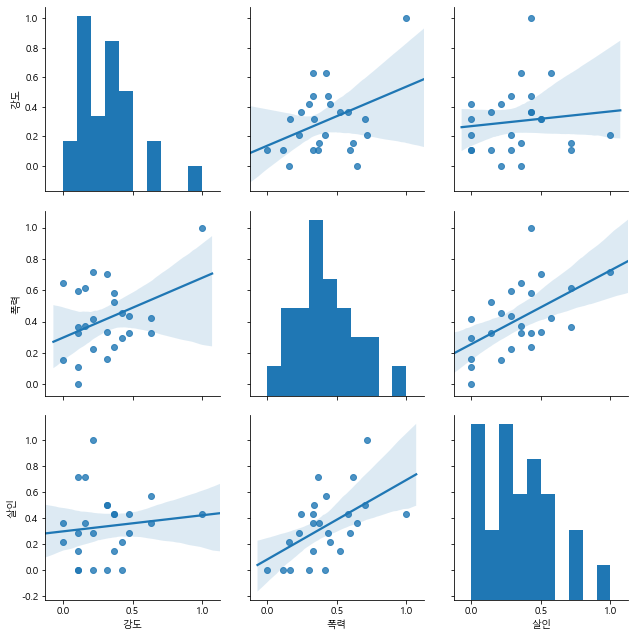

In [82]:
#변수간의 상관성 => 산포 행렬
# 범죄들간의 연관성 
# kind='reg' 선형회귀
sns.pairplot( crime_anal_norm, 
              vars = ['강도','폭력','살인'], 
              size =3, 
              kind ='reg')
plt.show()

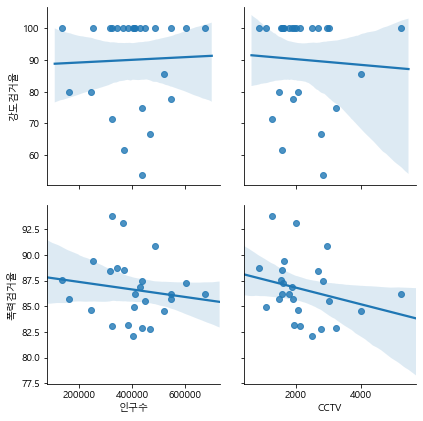

In [83]:
# X : 인구수, CCTV, Y: 강도검거율, 폭력검거율
sns.pairplot(crime_anal_norm,
            x_vars=['인구수','CCTV'],
            y_vars=['강도검거율','폭력검거율'],
            size =3 ,kind ='reg')
plt.show()
# 인구수와 cctv 수는 검거율과 관련이 없다!!
# 원 cctv의 목적은 예방에 촛점이 맞춰져 있고, 검거 자체는 인구와 상관없는 요인들의 
# 영향을 받는다

In [84]:
# 검거 항목의 최대값(최고값)100으로 한정하고, 그 기준을 값을 배치 
# 정규화 => 값을 동일 범위애로 배치 
crime_anal_norm['검거'] = crime_anal_norm['검거']/crime_anal_norm['검거'].max()*100

In [85]:
crime_anal_norm['검거']

자치구
강남구      90.658174
강동구      97.400425
강북구      88.308492
강서구      93.767633
관악구      88.262360
광진구      80.449525
구로구      79.956724
금천구      96.095302
노원구      87.732638
도봉구     100.000000
동대문구     96.794209
동작구      83.216010
마포구      89.949141
서대문구     94.849146
서초구      76.459876
성동구      92.247281
성북구      91.358285
송파구      91.374543
양천구      77.445992
영등포구     82.610569
용산구      87.894267
은평구      99.170251
종로구      76.014441
중구       64.122479
중랑구      92.751632
Name: 검거, dtype: float64

In [86]:
crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거',ascending=False)
crime_anal_norm_sort.head(2)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
자치구,,,,,,,,,,,,,,
도봉구,0.000000,0.105263,0.000000,0.000000,0.000000,100.000000,100.0,100.0,65.876777,88.712242,341649,858,0.105263,100.000000
은평구,0.250497,0.157895,0.357143,0.301962,0.369904,92.608696,100.0,100.0,67.339582,90.868794,487666,2962,1.437401,99.170251


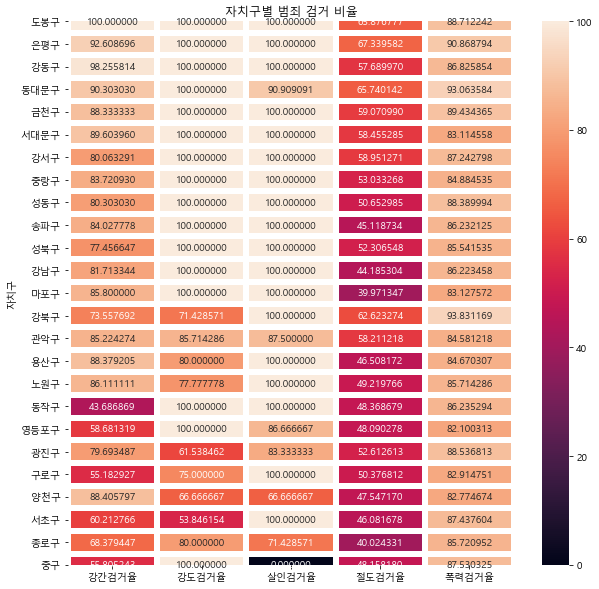

In [87]:
#히트맵을 통해서 검거율을 확인
# y: 자치구, x:xx검거율
# 데이터로 사용 crime_anal_norm_sort
plt.figure(figsize=(10,10))
sns.heatmap(crime_anal_norm_sort[cols], annot=True, fmt='f',linewidths=5)
plt.title('자치구별 범죄 검거 비율')
plt.show()

In [88]:
#범죄 발생 통계 
# y: 자치구 (범죄비율이 높은 수 ),x:5대 범죄
# 히트맵 표현 

### 지도 시각화 (공간 시각화의 한범주)

- folium을 이용하고, geoJson 데이터를 이용하여 지도상에 행정구역을 표현
- 구역별 정보를 시각화 한다
- 연습 : 미국 지도에 실업율 데이터를 가지고 확인
- 적용 : 서울시 지도에 경찰서 표시, 검거율, 발생율에 따른 행정구역의 칼라맵적용, 마커를 통해 포인트 설정 및 폴리곤표현으로 검거율은 표시
- 응용 : 주유소정보데이터 부산시 행정구역으료 표현, 자치구별 가장 저렴한 주요소 마킹,행정구역별 주유가격 평균을 통해서 칼라맵으로 표시, 브랜드별(6개) 알뜰주유수 -> 브랜드대비, 진짜 싼지 체크!!

In [89]:
#서울을 행정구역은 나눠서 드로잉 -> 자치구별로 드로잉 
import json

In [90]:
#한글의 경우 인코딩 처리를 해서 지도에 데이터로 삽입
geo_str=json.load(open('../data/seoul.json', encoding = 'utf-8'))

In [91]:
type(geo_str)

dict

In [92]:
gps= [37.5289126,126.9957077]

In [93]:
crime_anal_norm.index

Index(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
       '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구',
       '용산구', '은평구', '종로구', '중구', '중랑구'],
      dtype='object', name='자치구')

In [94]:
crime_anal_norm.columns

Index(['강간', '강도', '살인', '절도', '폭력', '강간검거율', '강도검거율', '살인검거율', '절도검거율',
       '폭력검거율', '인구수', 'CCTV', '범죄', '검거'],
      dtype='object')

### folium 
- 파이썬을 이용해 지도 시각화를 제공하는 라이브러리

<a href='http://localhost:8888/notebooks/Desktop/projects/analysis/pandas/basic/Folium_basic.ipynb'>기초학습</a>

In [95]:
import folium

In [96]:
map_seoul = folium.Map( location=gps, zoom_start=10)
#행정구역을 표현
map_seoul.choropleth(geo_data=geo_str,
                     data=crime_anal_norm,
                     columns=[crime_anal_norm.index,'범죄'],
                     key_on='feature.id',
                     fill_color='YlGn',
                     legend_name='서울시 자치구별 범죄비율'
                      )
map_seoul

C:\Users\sun41\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [97]:
crime_anal_norm['범죄'].max()

4.428571428571429

In [98]:
# 범죄 값을 정규화하여 다시 시도
# 최대값은 5.0 기준 -> 재 정규화
# 범죄 발생율 = 범죄/5.0*100
#컬러 PuRd

tmp =crime_anal_norm['범죄']/crime_anal_norm['범죄'].max()*100

map_seoul = folium.Map( location=gps, zoom_start=10)
#행정구역을 표현
map_seoul.choropleth(geo_data=geo_str,
                     data=crime_anal_norm,
                     columns=[crime_anal_norm.index,'범죄'],
                     key_on='feature.id',
                     fill_color='PuRd',
                     legend_name='서울시 자치구별 범죄비율'
                      )
map_seoul

In [100]:
# 인구수 대비 범죄응 계산하여 범죄 발생율 대입
# 범죄발생율 = 범죄(정규화된것)/인구수*100
#컬러 PuRd

tmp =crime_anal_norm['범죄']/crime_anal_norm['인구수'].max()*100

map_seoul = folium.Map( location=gps, zoom_start=10)
#행정구역을 표현
map_seoul.choropleth(geo_data=geo_str,
                     data=tmp,
                     columns=[crime_anal_norm.index, tmp],
                     key_on='feature.id',
                     fill_color='PuRd',
                     legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄가중치 동일)'
                      )
map_seoul

In [101]:
#인구데베 범죄비율은 종로구가 1위 
#강남구는 그럼에도 불구하고 상위권 3위 이내에 존재 

In [102]:
tmp_pop = np.sum(crime_anal[crime_anal.columns[:5]],axis=1)

In [104]:
#인구수 대비 범죄를 계산 하여 범죄발생 율 대입 
#범죄발생률 = 5대 범죄(순수카운트)/인구수*100
#종로구가 실질적인 범죄 우발지역 자치구이다.

tmp =tmp_pop/crime_anal_norm['인구수']*100
map_seoul = folium.Map( location=gps, zoom_start=10)
#행정구역을 표현
map_seoul.choropleth(geo_data=geo_str,
                     data=tmp,
                     columns=[crime_anal_norm.index, tmp],
                     key_on='feature.id',
                     fill_color='PuRd',
                     legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄가중치 동일)'
                      )
map_seoul

## 경찰서별 검거현황과 자치구별 범죄 발생현황을 표현
- 경찰서를 마킹
- 검거(순수카운트, 총량)를 서클마커 표시 => 작으면 적당히 스케일을 키운다
- 범죄(총량) 자치구별 색상표시

In [105]:
crime_data.head()
#관할서
crime_data.index

Index(['강남', '강동', '강북', '강서', '관악', '광진', '구로', '금천', '남대문', '노원', '도봉',
       '동대문', '동작', '마포', '방배', '서대문', '서부', '서초', '성동', '성북', '송파', '수서',
       '양천', '영등포', '용산', '은평', '종로', '종암', '중랑', '중부', '혜화'],
      dtype='object', name='구분')

In [106]:
crime_data['위도'], crime_data['경도']

(구분
 강남      37.5093899463715
 강동      37.5286763457485
 강북       37.637408362838
 강서      37.5397837301896
 관악      37.4745875338795
 광진      37.5428136101647
 구로      37.4948844667899
 금천     37.45725314643252
 남대문    37.55478043476484
 노원      37.6423345266253
 도봉      37.6533976253312
 동대문     37.5850804205685
 동작      37.5131469479959
 마포      37.5510118582052
 방배     37.48155944749938
 서대문     37.5649023404956
 서부     37.61273115700761
 서초      37.4956126696023
 성동      37.5617947420747
 성북     37.58989767143614
 송파      37.5019775317251
 수서      37.4934972653425
 양천      37.5165549067037
 영등포       37.52585220719
 용산      37.5411811395942
 은평      37.6285242467996
 종로      37.5755413947569
 종암       37.602095614954
 중랑      37.6182390801576
 중부      37.5636199296203
 혜화      37.5718915247338
 Name: 위도, dtype: object, 구분
 강남       127.067070541137
 강동       127.126894359114
 강북       127.027340967017
 강서       126.829985881518
 관악       126.951062346192
 광진       127.083842771963

In [107]:
# 5대 범죄에 대한 총량
tmp_pop=np.sum(crime_anal[ crime_anal.columns[:5] ], axis=1)

In [109]:
# 검거 컬럼만 뽑기
cols=list( filter(lambda x: x.find('검거')>0, crime_data.columns) )

In [110]:
#범죄의 총량을 구하는 부분 
tmp_catch =np.sum(crime_data[cols],axis=1)
tmp_catch[:2]

구분
강남    3117
강동    3245
dtype: int64

In [111]:
#서클의 크기가 너무 크면 애매 => 크기를 10으로 제한
tmp_catch =tmp_catch/tmp_catch.max()*10

In [116]:
map_seoul = folium.Map( location=gps, zoom_start=10 )
#행정구역을 표현
folium.Choropleth(geo_data=geo_str,
                     name='choropleth',
                     data=tmp_pop,
                     columns=[crime_anal_norm.index, tmp_pop],
                     key_on='feature.id',
                     fill_color='PuRd',
                     legend_name='서울시 자치구별 인구대비 범죄비율(5대 범죄가중치 동일)'
                      ).add_to(map_seoul)

#경찰서 마커 
for idx in range (len(crime_data.index)):
    #경찰서 위치 정보 -> 위도 경도의 정보를 담은 변수를 생성
    tmp_gps = [crime_data['위도'][idx],crime_data['경도'][idx]]
    # 마킹
    folium.Marker(tmp_gps, popup='서울%s경찰서'%crime_data.index[idx],
                  icon=folium.Icon(icon='info-Sign',color='red')).add_to(map_seoul)
    folium.CircleMarker(tmp_gps,
                       radius=tmp_catch[idx]*2,
                        popup='%s서 검거량'%crime_data.index[idx],
                        coloe='#3186cc',fill_color='#00ff00').add_to(map_seoul)
map_seoul